In [1]:
import time
import sys, os
import pickle
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from veloproj import *
from veloproj.model import leastsq_pt
from IPython import display
from matplotlib import pyplot as plt
import anndata

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--data-dir', '/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad',
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--exp-name', 'baseline_scNT',
                               '--model-name', 'baseline_tmp.cpt',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                              ])

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("0", "15"), ("15", "30"), ("30", "60"), ("60", "120")]
k_cluster = "time"
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, model, lr=args.lr, weight_decay=args.weight_decay, save_name="tmp.cpt"):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr = args.lr  
    i, losses = 0, [sys.maxsize]  
    min_loss = losses[-1]
    model_saved = False

    model.train()
    while i < args.n_epochs:
        i += 1
        loss = train_step_AE([tensor_s, tensor_u], model, optimizer, xyids=[0, 1], device=device)
        losses.append(loss)
        if i % args.log_interval == 0:
            if losses[-1] < min_loss:
                min_loss = losses[-1]
                torch.save(model.state_dict(), os.path.join(args.output, save_name))
                model_saved = True
            else:
                if model_saved:
                    model.load_state_dict(torch.load(os.path.join(args.output, save_name)))
                    model = model.to(device)
                lr *= args.lr_decay
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

            print("Train Epoch: {:2d}/{:2d} \tLoss: {:.6f}"
                  .format(i, args.n_epochs, losses[-1]))

    plt.plot(losses[1:])
    if losses[-1] < min_loss:
        torch.save(model.state_dict(), os.path.join(args.output, save_name))
    return model

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
adata.obs['time'] = adata.obs.time.astype('category')
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
Filtered out 39141 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
AnnData object with n_obs × n_vars = 3066 × 2000
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


computing velocities
    finished (0:00:00) --> added 
    'stc_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'stc_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'stc_velocity_length' (adata.obs)
--> added 'stc_velocity_confidence' (adata.obs)
--> added 'stc_velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'stc_velocity_umap', embedded velocity vectors (adata.obsm)


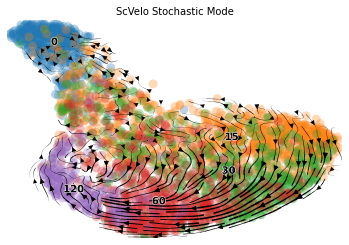

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.18051782, ('15', '30'): 0.18487221, ('30', '60'): 0.23318258, ('60', '120'): 0.26257157}
Total Mean: 0.2152860462665558
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.8822476, ('15', '30'): 0.8497245, ('30', '60'): 0.8860252, ('60', '120'): 0.9495538}
Total Mean: 0.8918877243995667
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.18786003770086088, ('15', '30'): 0.18276909526616839, ('30', '60'): 0.26048335897839736, ('60', '120'): 0.37983926077447216}
Total Mean: 0.2527379381799747
# In-cluster Coherence
{'0': 0.915023, '120': 0.9611259, '15': 0.8694032, '30': 0.8747747, '60': 0.95134073}
Total Mean: 0.9143335223197937
# In-cluster Confidence
{'0': 0.5655646301155922, '120': 0.5211546006816554, '15': 0.5153005838784248, '30': 0.5523763634938027, '60': 0.6307276948395397}
Total Mean: 0.557024774601803


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity')
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata, vkey="stc_velocity", basis='X_umap', color=['time'],
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, k_cluster, "stc_velocity")

In [8]:
spliced = adata.layers['Ms']
unspliced = adata.layers['Mu']
tensor_s, tensor_u = torch.FloatTensor(spliced).to(device), torch.FloatTensor(unspliced).to(device)
tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

Train Epoch: 100/20000 	Loss: 6.082361
Train Epoch: 200/20000 	Loss: 6.066586
Train Epoch: 300/20000 	Loss: 6.048912
Train Epoch: 400/20000 	Loss: 6.027511
Train Epoch: 500/20000 	Loss: 6.001272
Train Epoch: 600/20000 	Loss: 5.971152
Train Epoch: 700/20000 	Loss: 5.937881
Train Epoch: 800/20000 	Loss: 5.902299
Train Epoch: 900/20000 	Loss: 5.864507
Train Epoch: 1000/20000 	Loss: 5.824921
Train Epoch: 1100/20000 	Loss: 5.783354
Train Epoch: 1200/20000 	Loss: 5.739633
Train Epoch: 1300/20000 	Loss: 5.693726
Train Epoch: 1400/20000 	Loss: 5.645812
Train Epoch: 1500/20000 	Loss: 5.595551
Train Epoch: 1600/20000 	Loss: 5.542742
Train Epoch: 1700/20000 	Loss: 5.487461
Train Epoch: 1800/20000 	Loss: 5.429478
Train Epoch: 1900/20000 	Loss: 5.369129
Train Epoch: 2000/20000 	Loss: 5.306521
Train Epoch: 2100/20000 	Loss: 5.241899
Train Epoch: 2200/20000 	Loss: 5.175300
Train Epoch: 2300/20000 	Loss: 5.107018
Train Epoch: 2400/20000 	Loss: 5.036978
Train Epoch: 2500/20000 	Loss: 4.965174
Train Epo

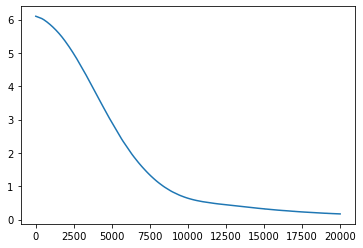

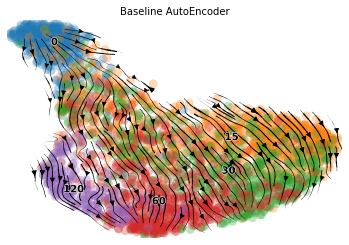

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.13759603, ('15', '30'): 0.12868418, ('30', '60'): 0.04168049, ('60', '120'): 0.040592507}
Total Mean: 0.08713829517364502
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.9999812, ('15', '30'): 0.9999785, ('30', '60'): 0.99997723, ('60', '120'): 0.99997437}
Total Mean: 0.9999778270721436
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.5401848462445571, ('15', '30'): 0.41344952104104854, ('30', '60'): 0.18491266242813761, ('60', '120'): -0.16229981835578938}
Total Mean: 0.24406180283948847
# In-cluster Coherence
{'0': 0.9999848, '120': 0.9999857, '15': 0.9999817, '30': 0.9999808, '60': 0.99998057}
Total Mean: 0.9999826550483704
# In-cluster Confidence
{'0': 0.9999755614289235, '120': 0.9999725441058793, '15': 0.999973316404832, '30': 0.9999720054641055, '60':

In [9]:
def expBaseAE(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    
    model = get_baseline_AE(in_dim, z_dim, h_dim).to(device)
    model = main_AE(args, model, save_name=f"baseAE_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Baseline AutoEncoder",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline AutoEncoder'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expBaseAE(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Train Epoch: 100/20000 	Loss: 6.065248
Train Epoch: 200/20000 	Loss: 6.058665
Train Epoch: 300/20000 	Loss: 6.050345
Train Epoch: 400/20000 	Loss: 6.039126
Train Epoch: 500/20000 	Loss: 6.024553
Train Epoch: 600/20000 	Loss: 6.007249
Train Epoch: 700/20000 	Loss: 5.988050
Train Epoch: 800/20000 	Loss: 5.967268
Train Epoch: 900/20000 	Loss: 5.944838
Train Epoch: 1000/20000 	Loss: 5.920630
Train Epoch: 1100/20000 	Loss: 5.894544
Train Epoch: 1200/20000 	Loss: 5.866509
Train Epoch: 1300/20000 	Loss: 5.836483
Train Epoch: 1400/20000 	Loss: 5.804457
Train Epoch: 1500/20000 	Loss: 5.770460
Train Epoch: 1600/20000 	Loss: 5.734600
Train Epoch: 1700/20000 	Loss: 5.697004
Train Epoch: 1800/20000 	Loss: 5.657778
Train Epoch: 

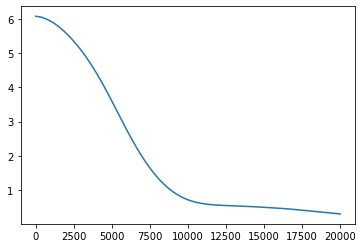

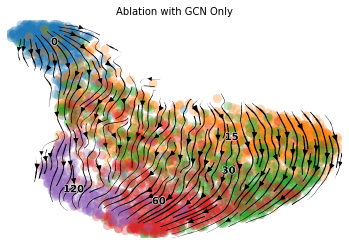

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.070916094, ('15', '30'): 0.07381361, ('30', '60'): 0.04067354, ('60', '120'): 0.060209993}
Total Mean: 0.0614033080637455
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.99998975, ('15', '30'): 0.99998975, ('30', '60'): 0.9999903, ('60', '120'): 0.9999915}
Total Mean: 0.9999902844429016
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.6868624144740431, ('15', '30'): 0.4731692001508155, ('30', '60'): 0.3299267062199645, ('60', '120'): 0.25544572424669604}
Total Mean: 0.4363510112728798
# In-cluster Coherence
{'0': 0.99999154, '120': 0.9999939, '15': 0.9999905, '30': 0.99999106, '60': 0.99999225}
Total Mean: 0.9999918937683105
# In-cluster Confidence
{'0': 0.9999901920357006, '120': 0.9999921390734821, '15': 0.9999899382990692, '30': 0.9999900659201706, '60': 

In [10]:
def expAblationCohAgg(adata, exp_metrics):
    n_cells, n_genes = adata.X.shape
    in_dim = n_genes
    z_dim = args.z_dim
    h_dim = args.h_dim
    g_basis = args.nb_g_src
    model = get_ablation_CohAgg(
                                adata,
                                in_dim,
                                z_dim,
                                h_dim,
                                g_basis,
                                device)
    model = main_AE(args, model, save_name=f"CohAgg_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
        
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with GCN Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation GCN Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationCohAgg(adata, exp_metrics)

Train Epoch: 100/20000 	Loss: 6.023990
Train Epoch: 200/20000 	Loss: 5.980527
Train Epoch: 300/20000 	Loss: 5.814541
Train Epoch: 400/20000 	Loss: 5.570839
Train Epoch: 500/20000 	Loss: 5.313594
Train Epoch: 600/20000 	Loss: 5.082974
Train Epoch: 700/20000 	Loss: 4.904608
Train Epoch: 800/20000 	Loss: 4.771292
Train Epoch: 900/20000 	Loss: 4.662079
Train Epoch: 1000/20000 	Loss: 4.566228
Train Epoch: 1100/20000 	Loss: 4.480483
Train Epoch: 1200/20000 	Loss: 4.402385
Train Epoch: 1300/20000 	Loss: 4.329697
Train Epoch: 1400/20000 	Loss: 4.260717
Train Epoch: 1500/20000 	Loss: 4.196619
Train Epoch: 1600/20000 	Loss: 4.133212
Train Epoch: 1700/20000 	Loss: 4.075948
Train Epoch: 1800/20000 	Loss: 4.024842
Train Epoch: 1900/20000 	Loss: 3.969217
Train Epoch: 2000/20000 	Loss: 3.922782
Train Epoch: 2100/20000 	Loss: 3.867841
Train Epoch: 2200/20000 	Loss: 3.818369
Train Epoch: 2300/20000 	Loss: 3.770107
Train Epoch: 2400/20000 	Loss: 3.720880
Train Epoch: 2500/20000 	Loss: 3.677684
Train Epo

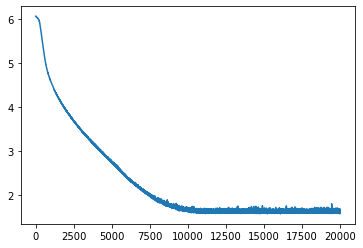

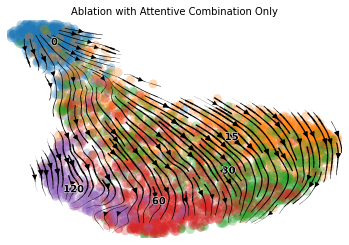

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.4960691, ('15', '30'): 0.50800914, ('30', '60'): 0.31204343, ('60', '120'): 0.38865727}
Total Mean: 0.4261947274208069
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.99893016, ('15', '30'): 0.9990094, ('30', '60'): 0.9989616, ('60', '120'): 0.998894}
Total Mean: 0.9989488124847412
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.6845321686134723, ('15', '30'): 0.4436842395211744, ('30', '60'): 0.25993836739964665, ('60', '120'): -0.04943800427075782}
Total Mean: 0.3346791928158839
# In-cluster Coherence
{'0': 0.99905115, '120': 0.9992579, '15': 0.9991335, '30': 0.99913263, '60': 0.99899936}
Total Mean: 0.999114990234375
# In-cluster Confidence
{'0': 0.9990532402224188, '120': 0.9990976735415211, '15': 0.9991462971527539, '30': 0.9991180664640806, '60': 0.99

In [11]:
def expAblationAttComb(adata, exp_metrics):
    from sklearn.decomposition import PCA
    n_cells, n_genes = adata.X.shape
    z_dim = args.z_dim
    g_rep_dim = args.g_rep_dim
    h_dim = args.h_dim
    k_dim = args.k_dim
    gb_tau = args.gumbsoft_tau
    G_embeddings = PCA(n_components=g_rep_dim).fit_transform(adata.X.T.toarray())
    
    model = get_ablation_attcomb(
        z_dim,
        n_genes,
        n_cells,
        h_dim,
        k_dim,
        G_embeddings,
        g_rep_dim,
        gb_tau,
        device)
    
            
    model = main_AE(args, model, save_name=f"AttComb_{args.model_name}")
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Ablation with Attentive Combination Only",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Ablation AttComb Only'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expAblationAttComb(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


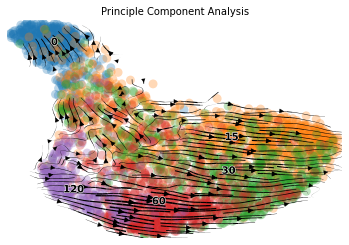

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.04856329, ('15', '30'): 0.05483842, ('30', '60'): 0.037259523, ('60', '120'): 0.017564744}
Total Mean: 0.03955649212002754
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.36887982, ('15', '30'): 0.3229974, ('30', '60'): 0.28273106, ('60', '120'): 0.30404493}
Total Mean: 0.31966331601142883
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): -0.5578148999239104, ('15', '30'): -0.05719334604844757, ('30', '60'): -0.22635977511778296, ('60', '120'): -0.5695681128316936}
Total Mean: -0.3527340334804586
# In-cluster Coherence
{'0': 0.49085838, '120': 0.40591335, '15': 0.38310617, '30': 0.39468685, '60': 0.39930806}
Total Mean: 0.4147745668888092
# In-cluster Confidence
{'0': 0.39106907283517317, '120': 0.30018567193700263, '15': 0.3414272193548255, '30': 0.32904653189

In [12]:
def expPCA(adata, exp_metrics):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(pca, 
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Principle Component Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline PCA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expPCA(adata, exp_metrics)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocity graph
    finished (0:00:01) --> added 
    'new_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'new_velocity_umap', embedded velocity vectors (adata.obsm)


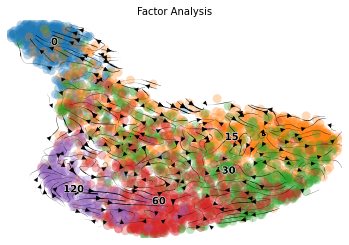

--> added 'new_velocity_length' (adata.obs)
--> added 'new_velocity_confidence' (adata.obs)
--> added 'new_velocity_confidence_transition' (adata.obs)
# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.019482557, ('15', '30'): 0.023656413, ('30', '60'): 0.024478905, ('60', '120'): 0.019456908}
Total Mean: 0.02176869660615921
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.09881322681953321, ('15', '30'): 0.17325760867664583, ('30', '60'): 0.14854702692602942, ('60', '120'): 0.159277182162716}
Total Mean: 0.14497376114623112
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): -0.3344263117694638, ('15', '30'): 0.0014988450519612727, ('30', '60'): 0.0507910069539618, ('60', '120'): -0.11976704957880253}
Total Mean: -0.10047587733558581
# In-cluster Coherence
{'0': 0.43288184603978414, '120': 0.34723624603605835, '15': 0.2318923067437208, '30': 0.316629822599614, '60': 0.3199371736564219}
Total Mean: 0.32971547901511983
# In-cluster Confidence
{'0': 0.216775435219

In [13]:
def expFA(adata, exp_metrics):
    from sklearn.decomposition import FactorAnalysis
    method = FactorAnalysis(n_components=args.z_dim)
    x, s, u, v = sklearn_decompose(method,
                                   tensor_x.detach().cpu().numpy(), 
                                   tensor_s.detach().cpu().numpy(), 
                                   tensor_u.detach().cpu().numpy(), 
                                   tensor_v.detach().cpu().numpy()
                                  )
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.nb_g_src)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis='X_umap', color=k_cluster,
                                    title="Factor Analysis",
                                    )  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Baseline FA'] = evaluate(adata, cluster_edges, k_cluster, "new_velocity")
    
expFA(adata, exp_metrics)

In [14]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)